In [1]:
# Import packages
import os
os.environ['WANDB_DISABLED'] = 'true'
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_metric
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,accuracy_score


def preprocessing(tweet):
    temp = tweet.lower()
    temp = re.sub('@[A-Za-z]+[A-Za-z0-9-_]+', ' ', temp)
    temp = re.sub(r'https\S+', '', temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub("[0-9]", " ", temp)
    temp = re.sub("\s\s+", " ", temp)
    return temp

In [2]:
# Define constants
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
SEED = 4222

MODEL_SAVE_PATH = "Model_4/electra"
MODEL_CHECKPOINT_PATH = "Model_4/electra_checkpoint"
MODEL_LOGGING_PATH = "Model_4/electra_checkpoint/logs"

In [3]:
#oversampling since there are much less negative sentiment tweets than positive or neutral
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 17)

full_training_data = pd.read_csv('full_training_data_noneutral.csv')
X_training_data_imb2 = pd.read_csv('full_training_data_noneutral.csv', usecols = [2])
Y_training_data_imb2 = pd.read_csv('full_training_data_noneutral.csv', usecols = [3])

X_training_data_over, Y_training_data_over = oversample.fit_resample(X_training_data_imb2, Y_training_data_imb2)



label_dict = {}
possible_labels = full_training_data.sentiment.unique()

for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index


print(Y_training_data_imb2['label'].value_counts())
print(Y_training_data_over['label'].value_counts())

X_training_data_over2 = X_training_data_over.tweet_text
Y_training_data_over2 = Y_training_data_over.label

#preprocessing the tweets

X_training_data_over2 = [preprocessing(tweet) for tweet in X_training_data_over2]
print(X_training_data_over2[:10])

1    6935
0    2420
Name: label, dtype: int64
0    6935
1    6935
Name: label, dtype: int64
['theo walcott is still shit\\u c watch rafa and johnny deal with him on saturday.', 'its not that i\\u m a gsp fan\\u c i just hate nick diaz. can\\u t wait for february.', 'iranian general says israel\\u s iron dome can\\u t deal with their missiles (keep talking like that and we may end up finding out)', 'with j davlar th. main rivals are team poland. hopefully we an make it a successful end to a tough week of training tomorrow.', 'talking about act\\u s && sat\\u s\\u c deciding where i want to go to college\\u c applying to colleges and everything about college stresses me out.', 'they may have a superbowl in dallas\\u c but dallas ain\\u t winning a superbowl. not with that quarterback and owner. ', ' i just watched it! sridevi\\u s comeback.... u remember her from the s?? sun mornings on nta ;)', 'one of my best th graders kory was excited after his touchdown today!! he did the victor cru

In [9]:
# Remember to change between imb and over
X_training_data_full = X_training_data_over2
Y_training_data_full = Y_training_data_over2
d = {'Polarity':Y_training_data_full,'text':X_training_data_full}
df = pd.DataFrame(data=d)

In [10]:
test = pd.read_csv('full_test_data.csv')

In [11]:
# Load ELECTRA tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator", do_lower_case = True)

In [12]:
# Import ELECTRA-base pretrained model
model = AutoModelForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=2)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [13]:
def dataset_conversion(train, test):
  """Converts pandas dataframe to Dataset."""

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)
#   val.reset_index(drop=True, inplace=True)

  train_dataset = Dataset.from_pandas(train)
  test_dataset = Dataset.from_pandas(test)
#   val_dataset = Dataset.from_pandas(val)

  return DatasetDict({"train": train_dataset,
                      "test": test_dataset})
#                       "val": val_dataset})

raw_datasets = dataset_conversion(df, test)

In [14]:
def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [15]:
# Tokenise datasets
SAMPLE_SIZE = 20
small_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
# small_val_dataset = tokenized_datasets["val"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))

full_train_dataset = tokenized_datasets["train"]
full_test_dataset = tokenized_datasets["test"]
# full_val_dataset = tokenized_datasets["val"]

In [16]:
full_train_dataset = full_train_dataset.rename_column("Polarity", "label")
full_test_dataset = full_test_dataset.rename_column("Polarity", "label")
# full_val_dataset = full_val_dataset.rename_column("Polarity", "label")

In [17]:
# Define custom metrics for computation
def compute_metrics(eval_pred):
    metric_acc = load_metric("accuracy")
    metric_rec = load_metric("recall")
    metric_pre = load_metric("precision")
    metric_f1 = load_metric("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    recall = metric_rec.compute(predictions=predictions, references=labels)["recall"]
    precision = metric_pre.compute(predictions=predictions, references=labels)["precision"]
    f1 = metric_f1.compute(predictions=predictions, references=labels)["f1"]

    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

In [18]:
# Define model and training parameters
training_args = TrainingArguments(
    output_dir=MODEL_CHECKPOINT_PATH,
    overwrite_output_dir = True,
#     report_to = 'wandb',
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    seed=SEED,
    # evaluation_strategy="epoch",
    logging_dir=MODEL_LOGGING_PATH,
    save_strategy="steps",
    save_steps=433
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
/usr4/cs505/orawal/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13870
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4335


Step,Training Loss
500,0.559600
1000,0.361400
1500,0.300900
2000,0.266200
2500,0.245300
3000,0.222200
3500,0.210700
4000,0.201200


Saving model checkpoint to Model_4/electra_checkpoint/checkpoint-433
Configuration saved in Model_4/electra_checkpoint/checkpoint-433/config.json
Model weights saved in Model_4/electra_checkpoint/checkpoint-433/pytorch_model.bin
tokenizer config file saved in Model_4/electra_checkpoint/checkpoint-433/tokenizer_config.json
Special tokens file saved in Model_4/electra_checkpoint/checkpoint-433/special_tokens_map.json
Saving model checkpoint to Model_4/electra_checkpoint/checkpoint-866
Configuration saved in Model_4/electra_checkpoint/checkpoint-866/config.json
Model weights saved in Model_4/electra_checkpoint/checkpoint-866/pytorch_model.bin
tokenizer config file saved in Model_4/electra_checkpoint/checkpoint-866/tokenizer_config.json
Special tokens file saved in Model_4/electra_checkpoint/checkpoint-866/special_tokens_map.json
Saving model checkpoint to Model_4/electra_checkpoint/checkpoint-1299
Configuration saved in Model_4/electra_checkpoint/checkpoint-1299/config.json
Model weights 

TrainOutput(global_step=4335, training_loss=0.28869559212126944, metrics={'train_runtime': 536.3962, 'train_samples_per_second': 129.289, 'train_steps_per_second': 8.082, 'total_flos': 2040252091699200.0, 'train_loss': 0.28869559212126944, 'epoch': 5.0})

In [20]:
trainer.state.log_history

[{'loss': 0.5596,
  'learning_rate': 8.846597462514419e-06,
  'epoch': 0.58,
  'step': 500},
 {'loss': 0.3614,
  'learning_rate': 7.693194925028837e-06,
  'epoch': 1.15,
  'step': 1000},
 {'loss': 0.3009,
  'learning_rate': 6.539792387543253e-06,
  'epoch': 1.73,
  'step': 1500},
 {'loss': 0.2662,
  'learning_rate': 5.38638985005767e-06,
  'epoch': 2.31,
  'step': 2000},
 {'loss': 0.2453,
  'learning_rate': 4.232987312572088e-06,
  'epoch': 2.88,
  'step': 2500},
 {'loss': 0.2222,
  'learning_rate': 3.0795847750865054e-06,
  'epoch': 3.46,
  'step': 3000},
 {'loss': 0.2107,
  'learning_rate': 1.926182237600923e-06,
  'epoch': 4.04,
  'step': 3500},
 {'loss': 0.2012,
  'learning_rate': 7.727797001153404e-07,
  'epoch': 4.61,
  'step': 4000},
 {'train_runtime': 536.3962,
  'train_samples_per_second': 129.289,
  'train_steps_per_second': 8.082,
  'total_flos': 2040252091699200.0,
  'train_loss': 0.28869559212126944,
  'epoch': 5.0,
  'step': 4335}]

In [21]:
predictions = trainer.predict(full_test_dataset)

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 14908
  Batch size = 16


In [22]:
print(predictions)

PredictionOutput(predictions=array([[-1.6495962,  1.7638965],
       [-1.6618115,  1.7538954],
       [-2.0869374,  2.2262235],
       ...,
       [-2.0822341,  2.2274313],
       [-2.0460558,  2.166389 ],
       [ 1.4849364, -1.8358902]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.3293605148792267, 'test_accuracy': 0.8946874161524014, 'test_recall': 0.8956595905989386, 'test_precision': 0.9527217741935484, 'test_f1': 0.9233098866744822, 'test_runtime': 39.8585, 'test_samples_per_second': 374.023, 'test_steps_per_second': 23.383})


In [23]:
logits = predictions.predictions
predicted_val = np.argmax(logits, axis=-1)
true_vals = predictions.label_ids

In [24]:
cf_matrix = confusion_matrix(true_vals,predicted_val)
print("Confusion matrix is: \n")
print(cf_matrix)

Confusion matrix is: 

[[3887  469]
 [1101 9451]]


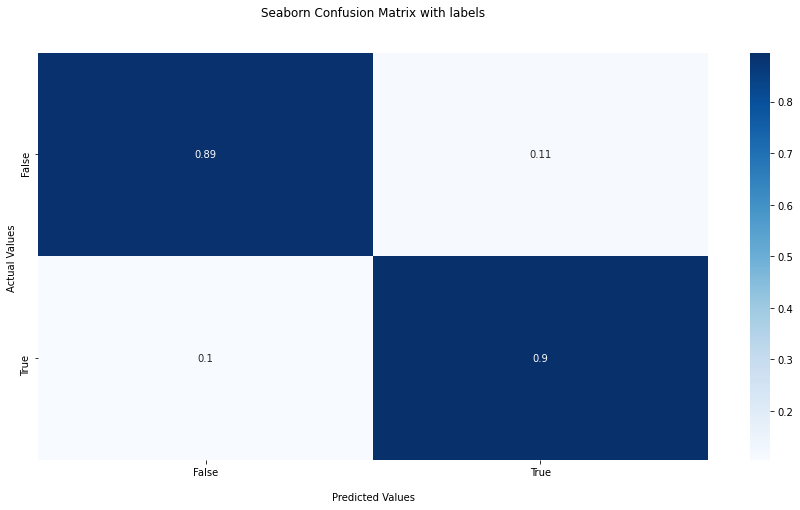

In [25]:
import seaborn as sns
plt.figure(figsize=(15, 7.5))

cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.savefig('NoisyConfusionPlot.png')
## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
print("Weighted F1 score is : \n ")
print(f1_score(true_vals,predicted_val,average='weighted'))

Weighted F1 score is : 
 
0.8966233537990147


In [27]:
def accuracy_per_class(preds, labels):
    label_dict = {'Negative' : 0 , 'Positive' : 1}
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')
    
    print(f'Total accuracy is : {accuracy_score(labels_flat,preds_flat)}\n')
    
    return accuracy_score(labels_flat,preds_flat)

In [28]:
accuracy_per_class(predicted_val, true_vals)

Class: Negative
Accuracy:3887/4356

Class: Positive
Accuracy:9451/10552

Total accuracy is : 0.8946874161524014



0.8946874161524014

# Final accuracy is 0.894 and weighted F1 score is 0.896